In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from quantum_systems import construct_psi4_system
from quantum_systems.time_evolution_operators import LaserField
from tdhf import HartreeFock
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.integrators import GaussIntegrator, RungeKutta4

In [2]:
class LaserPulse:
    def __init__(self, t0=0, td=5, omega=0.1, E=0.03):
        self.t0 = t0
        self.td = td
        self.omega = omega
        self.E = E  # Field strength

    def __call__(self, t):
        T = self.td
        delta_t = t - self.t0
        return (
            -(np.sin(np.pi * delta_t / T) ** 2)
            * np.heaviside(delta_t, 1.0)
            * np.heaviside(T - delta_t, 1.0)
            * np.cos(self.omega * delta_t)
            * self.E
        )

In [3]:
# System parameters
He = """
    He 0.0 0.0 0.0
    symmetry c1
    """

options = {"basis": "cc-pvdz", "scf_type": "pk", "e_convergence": 1e-6}
omega = 2.873_564_3
E = 100
laser_duration = 5

system = construct_psi4_system(He, options)
system.change_to_hf_basis(verbose=True, tolerance=1e-15)

HF converged to given precision in 13 iterations
Ehf: -2.855160477242741


In [4]:
integrator = GaussIntegrator(s=3, np=np, eps=1e-6)
#ntegrator = RungeKutta4(np=np)
tdccsd = TDCCSD(system, integrator=integrator, np=np, verbose=True)
t_kwargs = dict(theta=0, tol=1e-10)
tdccsd.compute_ground_state(t_kwargs=t_kwargs, l_kwargs=t_kwargs)
print(f"Ground state CCSD energy: {tdccsd.compute_ground_state_energy()}")

Iteration: 0	Residuals (t): [0.0013943426633353114, 0.15596810821106097]
Iteration: 1	Residuals (t): [0.0007468767992637332, 0.031946902250710965]
Iteration: 2	Residuals (t): [0.0002788117442195882, 0.006902978716533096]
Iteration: 3	Residuals (t): [8.940507633072663e-05, 0.0015724062647197458]
Iteration: 4	Residuals (t): [2.638688370529623e-05, 0.00037267628319896255]
Iteration: 5	Residuals (t): [7.399537249242007e-06, 9.05700538062827e-05]
Iteration: 6	Residuals (t): [2.0062730179796703e-06, 2.2324284031909176e-05]
Iteration: 7	Residuals (t): [5.315612430494457e-07, 5.5437046639919624e-06]
Iteration: 8	Residuals (t): [1.385747973818503e-07, 1.3818052770985657e-06]
Iteration: 9	Residuals (t): [3.571130453278705e-08, 3.450504928893949e-07]
Iteration: 10	Residuals (t): [9.126934265258e-09, 8.623591781401967e-08]
Iteration: 11	Residuals (t): [2.3186705875644554e-09, 2.1560483459320508e-08]
Iteration: 12	Residuals (t): [5.864935781822871e-10, 5.391332313721016e-09]
Iteration: 13	Residuals

In [5]:
polarization = np.zeros(3)
polarization[2] = 1
system.set_time_evolution_operator(
    LaserField(
        LaserPulse(td=laser_duration, omega=omega, E=E),
        polarization_vector=polarization,
    )
)

In [6]:
tdccsd.set_initial_conditions()
dt = 1e-3
T = 5
num_steps = int(T // dt) + 1
t_stop_laser = int(laser_duration // dt)

print(f"Laser stops @ {t_stop_laser}")

time_points = np.linspace(0, T, num_steps)

td_energies = np.zeros(len(time_points), dtype=np.complex128)
dip_z = np.zeros(len(time_points))
td_energies[0] = tdccsd.compute_energy()
phase = np.zeros_like(td_energies)
norm_t_2 = np.zeros_like(dip_z)

t, l = tdccsd.amplitudes

norm_t_2[0] = np.linalg.norm(t[1])

Laser stops @ 4999


In [7]:
for i, amp in tqdm.tqdm(
    enumerate(tdccsd.solve(time_points)), total=num_steps - 1
):
    t, l = amp
    energy = tdccsd.compute_energy()
    td_energies[i + 1] = energy
    phase[i + 1] = t[0][0]
    norm_t_2[i + 1] = np.linalg.norm(t[1])
    rho_qp = tdccsd.compute_one_body_density_matrix()
    rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

    z = system.dipole_moment[2].copy()
    dip_z[i + 1] = (np.einsum("qp,pq->", rho_qp_hermitian, z)).real

100%|██████████| 4999/4999 [03:39<00:00, 22.79it/s]


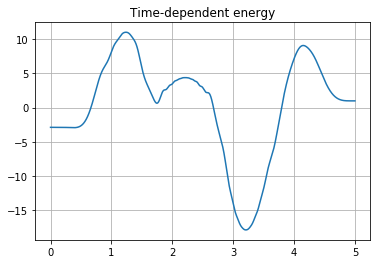

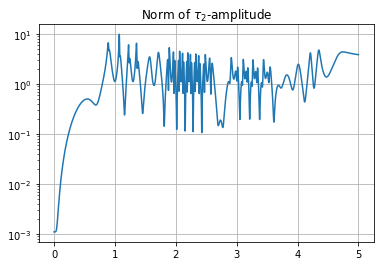

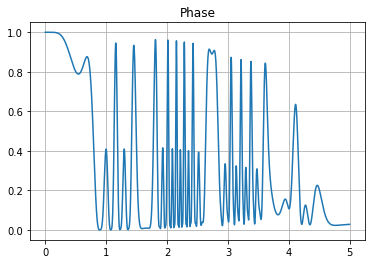

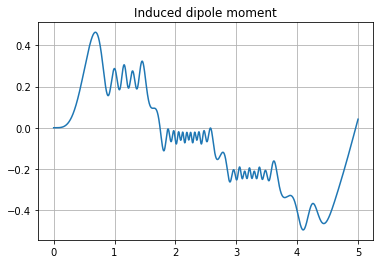

In [8]:
plt.figure()
plt.plot(time_points, td_energies.real)
plt.title("Time-dependent energy")
plt.grid()

plt.figure()
plt.semilogy(time_points, norm_t_2)
plt.title(r"Norm of $\tau_2$-amplitude")
plt.grid()

plt.figure()
plt.plot(time_points, np.abs(np.exp(phase)) ** 2)
plt.title("Phase")
plt.grid()

plt.figure()
plt.plot(time_points, dip_z)
plt.title("Induced dipole moment")
plt.grid()

plt.show()